### Definitions

October 9, 2017

In [1]:
# General definitions
%run '../definitions.ipynb'
%run '../treemakers/treemakers.py'
%run '../Analysis_class.ipynb'

#### Data location

In [2]:
processed_data_path = '/data/xenon/xams/run8/processed_v2_medium/'
processed_data_path_2 = '/data/xenon/xams/run8/processed_v2/'
minitree_path = '/data/xenon/xams/run8/minitrees/'

In [3]:
run_names_ambe_1 = get_run_list(processed_data_path, '170324_161817', '170324_215007') # Last file: 170322_081037
run_names_ambe_2 = get_run_list(processed_data_path_2, '170324_222017', '170327_070907') # Last file: 170327_070907
run_names_cs = get_run_list(processed_data_path, '170327_080108', '170327_095258')

Run list contains 12 files
Run list contains 104 files
Run list contains 12 files


In [4]:
treemakers = ['Fundamentals', ZeroFieldProperties]

#### Read function

In [5]:
def read_and_cut(run_names, processed_data_path, minitree_path, treemakers = None, cut=True, **kwargs):
    if 'pickle_file' in kwargs.keys():
        if not kwargs.get('force_reload', False):
            try:
                with open(kwargs['pickle_file'], 'rb') as f:
                    x = pickle.load(f)
                print('Read %d events from file %s' % (len(x.d), kwargs['pickle_file']))
                return x
            except:
                print('Pickle not found, now starting loading...')
                
    x = XAMSAnalysis(run_names, processed_data_path, minitree_path)    
    x.load(treemakers = treemakers, compute_properties=False)
    
    # Add properties
    x.d['s1'] = x.d['s1_area']
    x.add_z_from_s1_aft()
    x.corr_s1_ly_poly(ly_filename='../light_yield/data/cs137_ly_p2_sel2.pickle')
    x.add_g1g2_props(pickle_file='../light_yield/data/doke_sel2_ext.pickle')
    
    # Cuts
    if cut:
        x.cut_time_since_previous(apply=True)
        x.d = cuts.below(x.d, 'n_s1s', 2)
        x.d = cuts.above(x.d, 'n_s1s', 0)
        x.cut_fiducial_volume()
        
    if 'pickle_file' in kwargs.keys():
        with open(kwargs['pickle_file'], 'wb') as f:
            pickle.dump(x, f)

    return x

### Read data

In [8]:
ambe = read_and_cut(run_names_ambe_1, processed_data_path, minitree_path, treemakers=treemakers, 
                    compute_properties=False, cut=False, 
                    pickle_file = '/home/erik/win/data/xams_run8/zero_field_ambe_first_6h_uncut.pickle')
cs = read_and_cut(run_names_cs, processed_data_path, minitree_path, treemakers=treemakers, 
                  cut=False, compute_properties=False, 
                  pickle_file = '/home/erik/win/data/xams_run8/zero_field_cs_uncut.pickle')

Read 2909296 events from file zero_field_ambe_first_6h_uncut.pickle
Read 2706931 events from file zero_field_cs_uncut.pickle


In [9]:
ambe_2 = read_and_cut(run_names_ambe_2[-12:], processed_data_path_2, minitree_path, treemakers=treemakers, 
                    compute_properties=False, cut=False, 
                      pickle_file = '/home/erik/win/data/xams_run8/zero_field_ambe_last_6h_uncut.pickle')

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


Pickle not found, now starting loading...
Loaded 2859689 (2859.7 k) events.
Total live time: 20837.5 seconds (5.8 hours)
Found no z position, will write s1-aft-derived position to key `z`...


### Energy spectrum

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


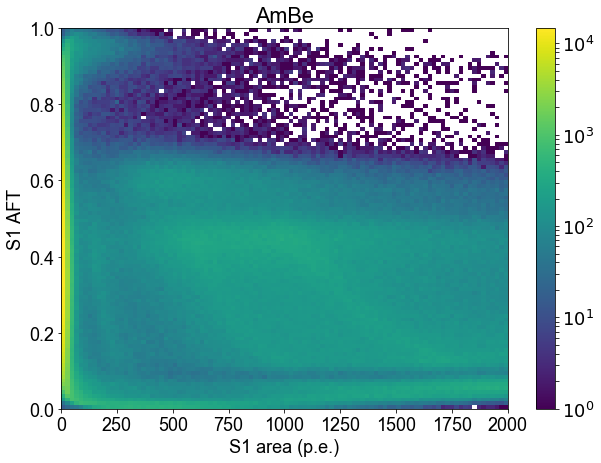

In [10]:
plt.hist2d(ambe_2.d['s1_area'], ambe_2.d['s1_area_fraction_top'], bins=100, norm=LogNorm(),
          range=((0, 2000), (0, 1)))
plt.ylabel('S1 AFT')
plt.xlabel('S1 area (p.e.)')
plt.colorbar()
plt.title('AmBe')
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


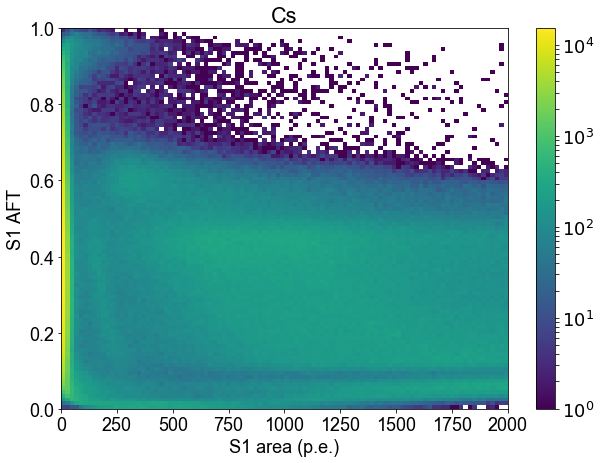

In [97]:
plt.hist2d(cs.d['s1_area'], cs.d['s1_area_fraction_top'], bins=100, norm=LogNorm(),
          range=((0, 2000), (0, 1)))
plt.ylabel('S1 AFT')
plt.xlabel('S1 area (p.e.)')
plt.colorbar()
plt.title('Cs')
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


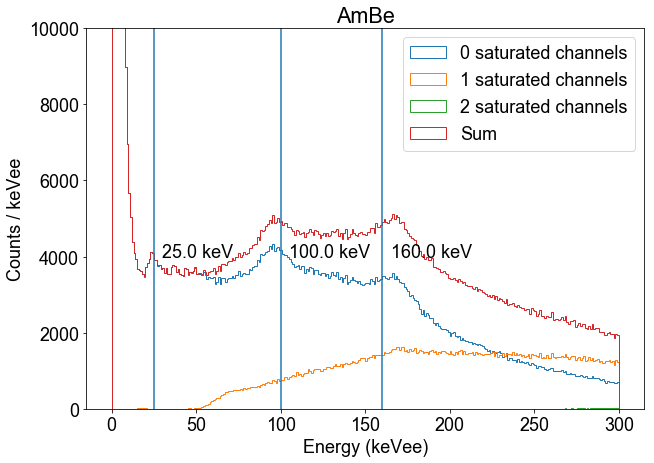

In [143]:
for n_channels_sat in [0, 1, 2]:
    sel = ambe.d['s1_n_saturated_channels'] == n_channels_sat
    plt.hist(ambe.d['e_ces'][sel], bins=300, range=(0, 300), histtype='step', 
             label='%d saturated channels' % n_channels_sat)
    plt.ylim(0, 10e3)
plt.hist(ambe.d['e_ces'], bins=300, range=(0, 300), histtype='step', label='Sum')
for _l in (25, 100, 160):
    plt.axvline(_l)
    plt.text(_l+ 5, 4000, '%.1f keV' % _l)
plt.legend()
plt.xlabel('Energy (keVee)')
plt.ylabel('Counts / keVee')
plt.title('AmBe')

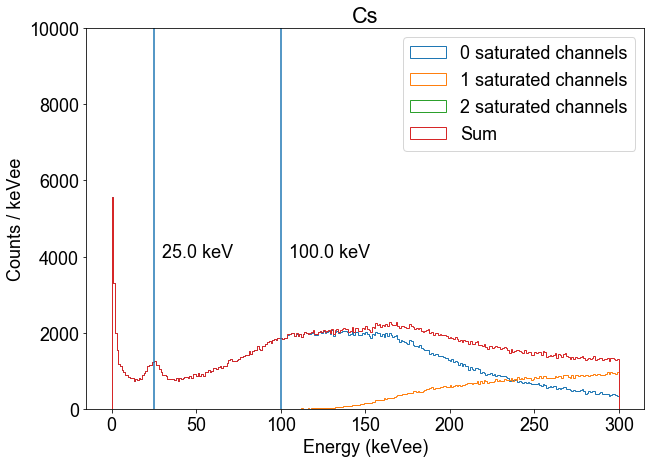

In [81]:
for n_channels_sat in [0, 1, 2]:
    sel = cs.d['s1_n_saturated_channels'] == n_channels_sat
    plt.hist(cs.d['e_ces'][sel], bins=300, range=(0, 300), histtype='step', 
             label='%d saturated channels' % n_channels_sat)
    plt.ylim(0, 10e3)
plt.hist(cs.d['e_ces'], bins=300, range=(0, 300), histtype='step', label='Sum')
for _l in (25, 100):
    plt.axvline(_l)
    plt.text(_l+ 5, 4000, '%.1f keV' % _l)
plt.legend()
plt.xlabel('Energy (keVee)')
plt.ylabel('Counts / keVee')
plt.title('Cs')

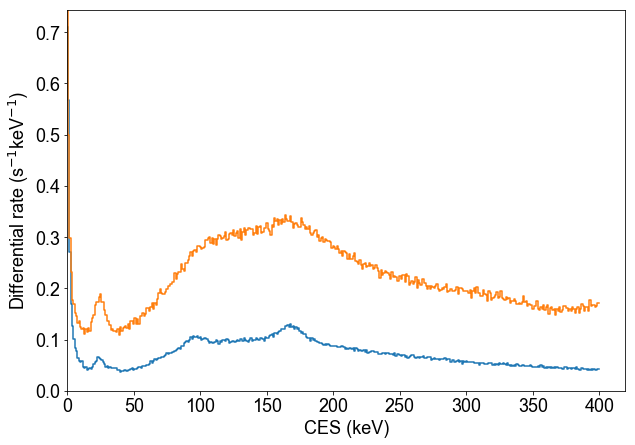

In [85]:
for x in (ambe, cs):
    x.plot_ces_rate()

plt.show()

In [86]:
cs.livetime

6636.3508414240005

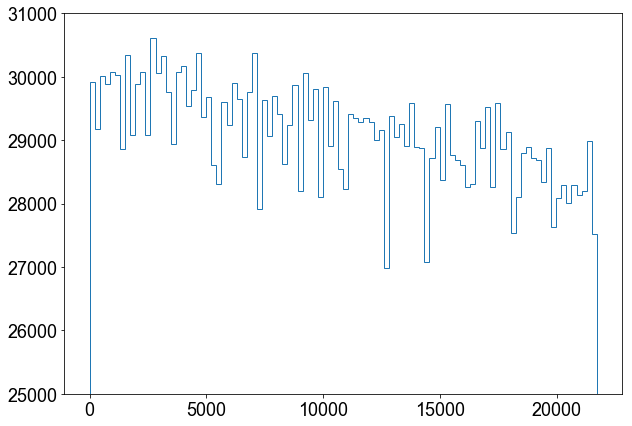

In [142]:
plt.hist(ambe.d['t'], bins=100, histtype='step')
plt.ylim(25e3, 31e3)
plt.show()

### Livetime correction to time since previous cut

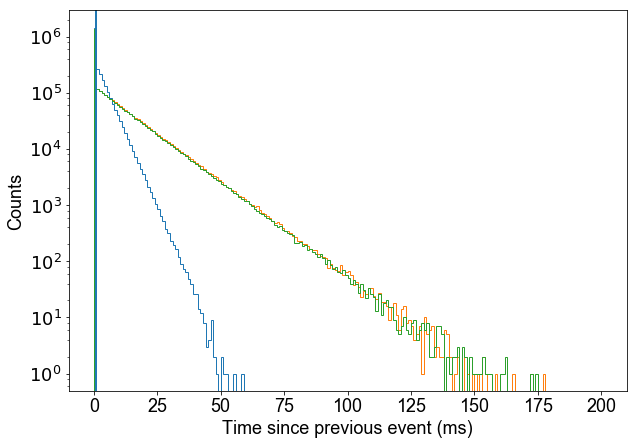

In [12]:
for x in (cs, ambe, ambe_2):
    x.cut_time_since_previous(apply=False, plot=True, bins=200, range=(0, 200), histtype='step')
plt.yscale('log')
plt.show()

In [113]:
def exp_decay(x, tau):
    return np.exp(-x/tau)

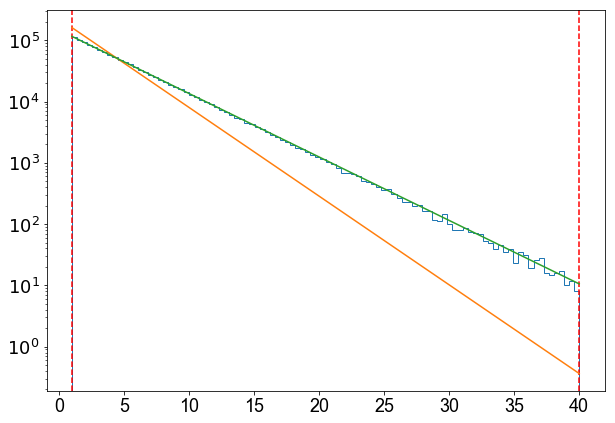

In [118]:
tau_cs, dtau_cs, _ = fit_unbinned(cs.d['ms_since_previous_event'], exp_decay, p0=[3.], 
                                  fit_range=(1, 40), plot=True, print_level=0)
plt.yscale('log')


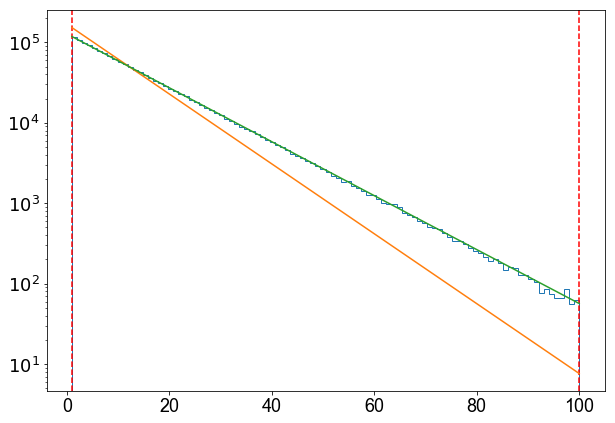

In [120]:
tau_ambe, dtau_ambe, _ = fit_unbinned(ambe.d['ms_since_previous_event'], exp_decay, p0=[10.], 
                                  fit_range=(1, 100), plot=True, print_level=0)
plt.yscale('log')


In [123]:
tau_ambe = tau_ambe[0]
tau_cs = tau_cs[0]

In [126]:
rate_ambe = 1 / (0.001 * tau_ambe)
rate_cs = 1 / (0.001 * tau_cs)

In [127]:
print('Rate found for AmBe: %.1f Hz. Actual rate: %.1f Hz' % (rate_ambe, ambe.rate))
print('Rate found for Cs:   %.1f Hz. Actual rate: %.1f Hz' % (rate_cs, cs.rate))

Rate found for AmBe: 77.2 Hz. Actual rate: 134.7 Hz
Rate found for Cs:   238.5 Hz. Actual rate: 407.9 Hz


In [128]:
def compute_lifetime_fraction_cut(tau, cut_value):
    '''
    Old-fashined integrals and exact solutions to the rescue!
    '''
    return 1 - np.exp(- cut_value / tau)

In [133]:
compute_lifetime_fraction_cut(tau_ambe, 1)

0.07427951921420195

In [134]:
compute_lifetime_fraction_cut(tau_cs, 1)

0.21219427268584701

In [ ]:
ambe.add_s1_waveforms(zerofield=True, verbose=True)

In [ ]:
ambe.d

In [ ]:
ambe.d['s1'] = ambe.d['s1_area']

In [ ]:
ambe.add_percentiles()

In [ ]:
def build_pulse_hist_entries(d, alignment_field):
    '''
    Align the S1 pulses. This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    The function returns two arrays, one containing the time points (shifted by the alignment field) and 
    one containing the weight, so that lower-than 1 bin sampling and alignment is possible.
    '''
    time_edges = np.linspace(-100, 300, 201)
    # Arbitrarily put the first sample EXACTLY at zero rather than at bin edges
    time = time_edges[:-1]
    time_entries = []
    weight_entries = []
    
    for i, ev in d.iterrows():
        time_entries.append(time + 100 - ev[alignment_field])
        weight_entries.append(np.array(ev['s1_pulse']) / ev['s1'])
    
    return np.concatenate(time_entries), np.concatenate(weight_entries)

def compute_average_pulse(d, alignment_field, dt = 2):
    '''
    Compute the average pulse, calling the underlying `build_pulse_hist_entries` routine. 
    This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    dt is sample time in ns, which may be lower than the raw sample of 2 ns. Go ahead and try!
    '''
    n_bins_time = np.floor(400 / dt) + 1
    if 400 % dt:
        print('Warning: please use a divisor of 400 for your time bins (i.e. 1, 0.2, 200, ...) .')
    time_edges = np.linspace(-100, 300, n_bins_time)
    times, weights = build_pulse_hist_entries(d, alignment_field)
    
    # This takes only the left bin edges, so that the first sample is zero.
    time = time_edges[:-1]
    amplitude, _ = np.histogram(times, bins=time_edges, weights=weights)
    # Normalization
    amplitude = amplitude / len(d) / dt
    
    return time, amplitude

def plot_average_pulse_in_slice(d, alignment_field, slice_field = 'cs1', dt = 2, slice_range=(0, np.inf), **kwargs):
    sel = (d[slice_field] >= slice_range[0]) & (d[slice_field] < slice_range[1])
    time, average_pulse = compute_average_pulse(d[sel], alignment_field, dt)
    plt.plot(time, average_pulse, **kwargs)
    plt.xlabel('Time (ns)')
    plt.ylabel('Average pulse ((%d ns)$^{-1}$)' % dt)
    return 

In [ ]:
plot_average_pulse_in_slice(ambe.d, 's1_10_percentile_point', dt=2, slice_field = 's1',
                            slice_range=(10, 20), label='NR', marker='.')
# plot_average_pulse_in_slice(er_ersel.d, 's1_10_percentile_point', dt=2, cs1_range=(30, 40), label='ER', marker='.')

plt.xlim(-50, 400)
plt.legend()
plt.yscale('log')
plt.show()